### Data analysis of Section 9 data.



In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *
import glob

plt.set_cmap('jet')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
Afx =  (27547, 165)
Afy =  (27547, 165)
U

<Figure size 640x480 with 0 Axes>

In [2]:
#dateID = '250116' forget this, data taken on different days
TR_IDs = np.loadtxt('../test_input_data/SA_ID_for_IF.txt')
BX_IDs = np.loadtxt('../test_input_data/SA_ID_for_IF_take2.txt')
repeat_IDs = BX_IDs[:4]
TR_IDs = np.concatenate((TR_IDs, BX_IDs[4:])) # all the IDs, but we use the same variable name
TR_IDs_unique = [x for x in TR_IDs if x not in saID[-5:]]
nSA = len(repeat_IDs)
print(nSA)

4


/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa422+ gmtMorph170614 -.h5: Wed Jan 29 15:52:44 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa422- gmtMorph170614 -.h5: Wed Jan 29 15:56:39 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set2 9.2 5-7 GMTO sa422- gmtMorph170614 -.h5: Wed Jan 29 16:00:02 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set2 9.2 5-7 GMTO sa422+ gmtMorph170614 -.h5: Wed Jan 29 16:04:11 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa322+ gmtMorph170614 -.h5: Wed Jan 29 14:39:26 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa322- gmtMorph170614 -.h5: Wed Jan 29 14:43:14 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/dat

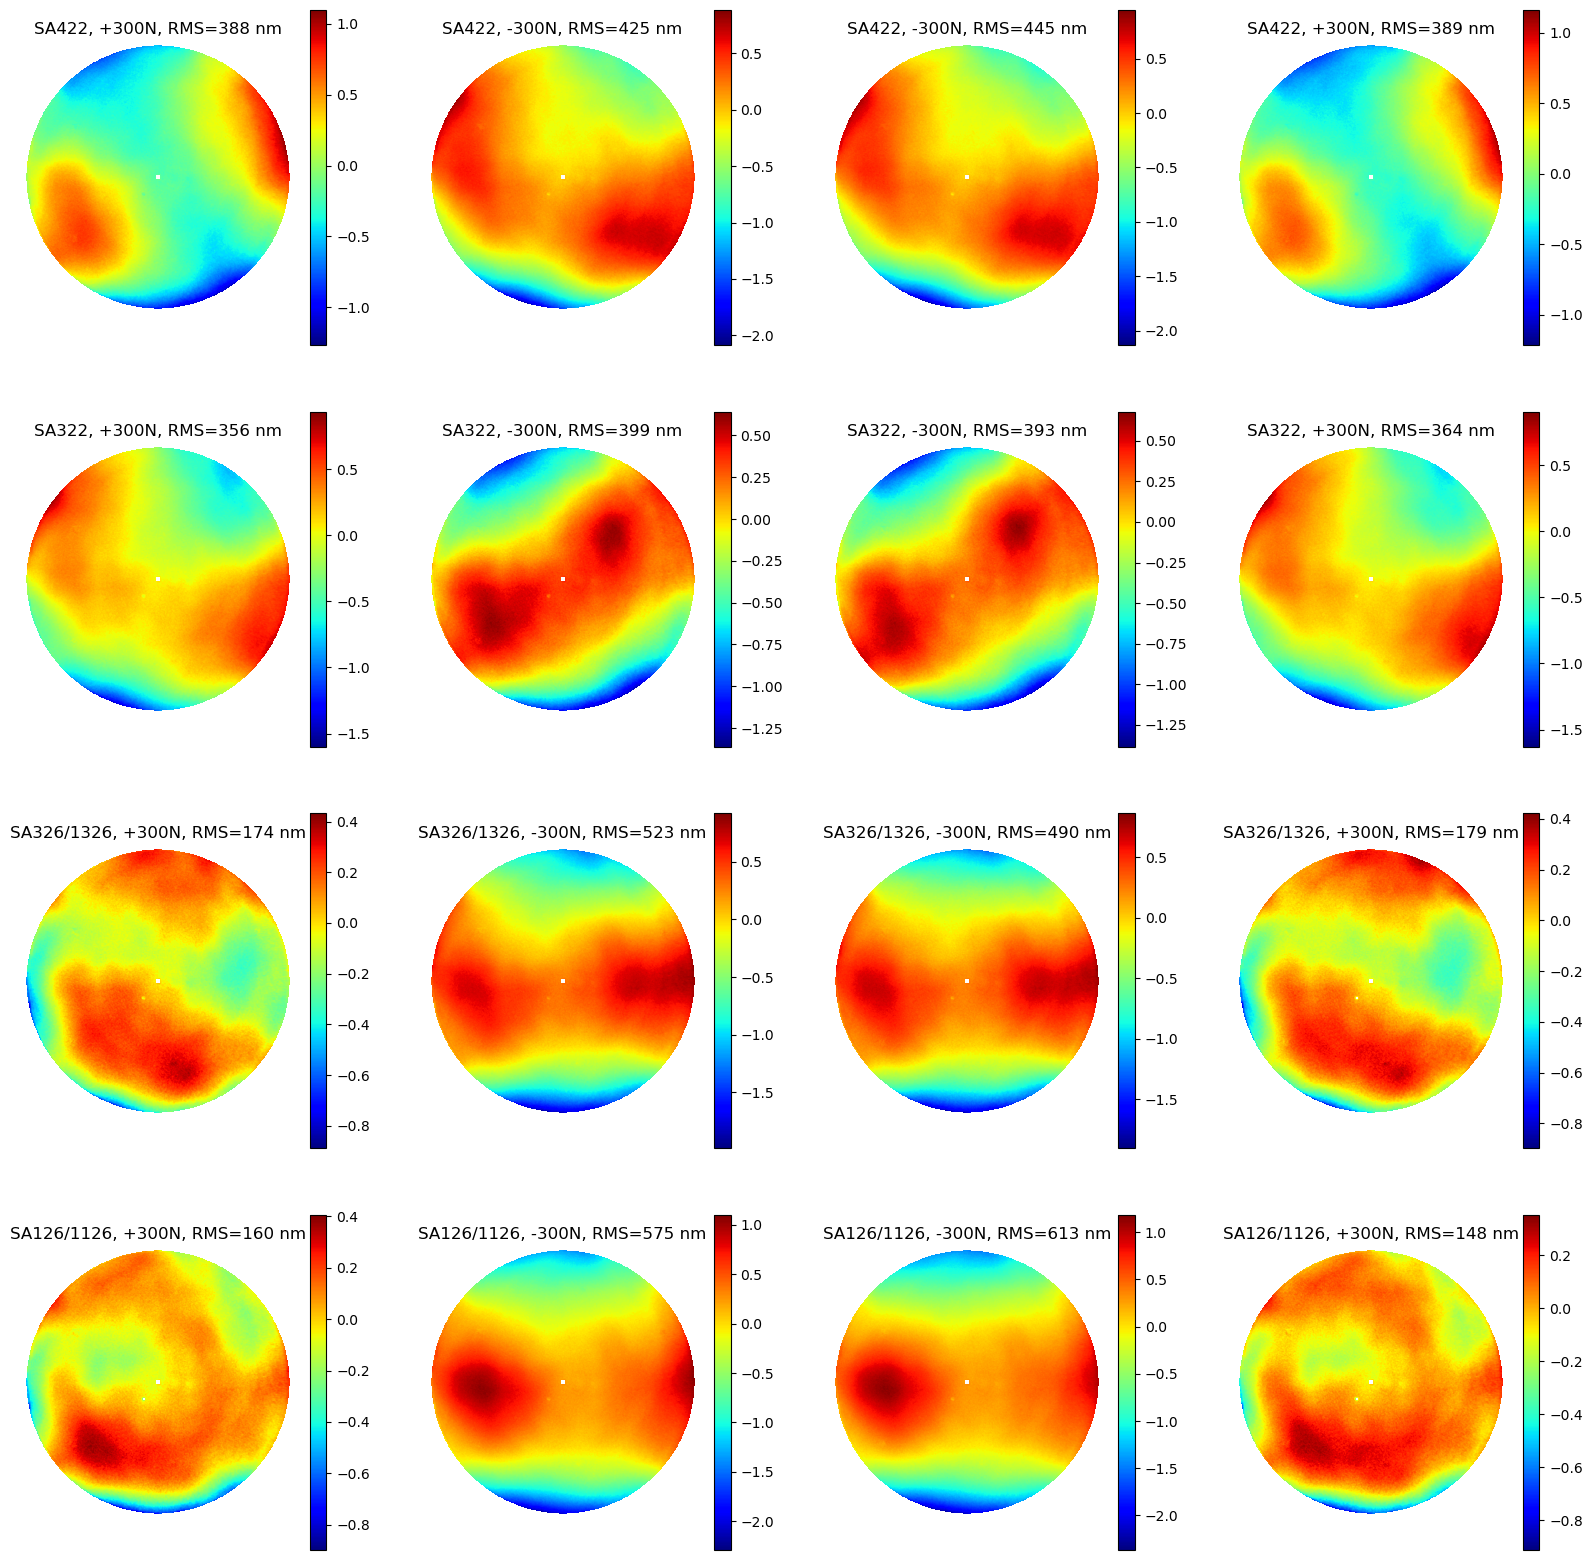

In [3]:
#look at all the +--+ maps
fig, ax = plt.subplots(nSA,4,figsize=(20,5*nSA))
i = 0
for mysaID in repeat_IDs:

    signedBend = ['set1*act%d +'%mysaID, 'set1*act%d -'%mysaID,'set2*act%d -'%mysaID, 'set2*act%d +'%mysaID ]
    signshort = '+--+'
    for bend in signedBend:
        irow = np.int8(i/4)
        icol = np.mod(i,4)
        i += 1

        globstring = '%s/Sec 9/*%s*-.h5'%(ml_data_dir, bend)
        if (mysaID in BX_IDs and mysaID in repeat_IDs):
            globstring = globstring.replace('Sec 9', 'Sec 9 Take 2')
            globstring = globstring.replace('act%d '%mysaID, 'sa%d'%mysaID)
        #print(globstring)
        fileset = sorted(glob.glob(globstring))
        #print(fileset)
        assert len(fileset)==1
        m1s,centerRow1,centerCol1,pixelSize1, ts = readH5Map(fileset)
        m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm

        img = ax[irow][icol].imshow(m1s, origin='lower')
        fig.colorbar(img, ax=ax[irow][icol])
        mytitle = 'SA%d, %s300N, RMS=%.0f nm'%(mysaID, signshort[icol], m1rms)
        if mysaID+1000 in TR_IDs[:10]:
            mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
        ax[irow][icol].set_title(mytitle)
        ax[irow][icol].axis('off')

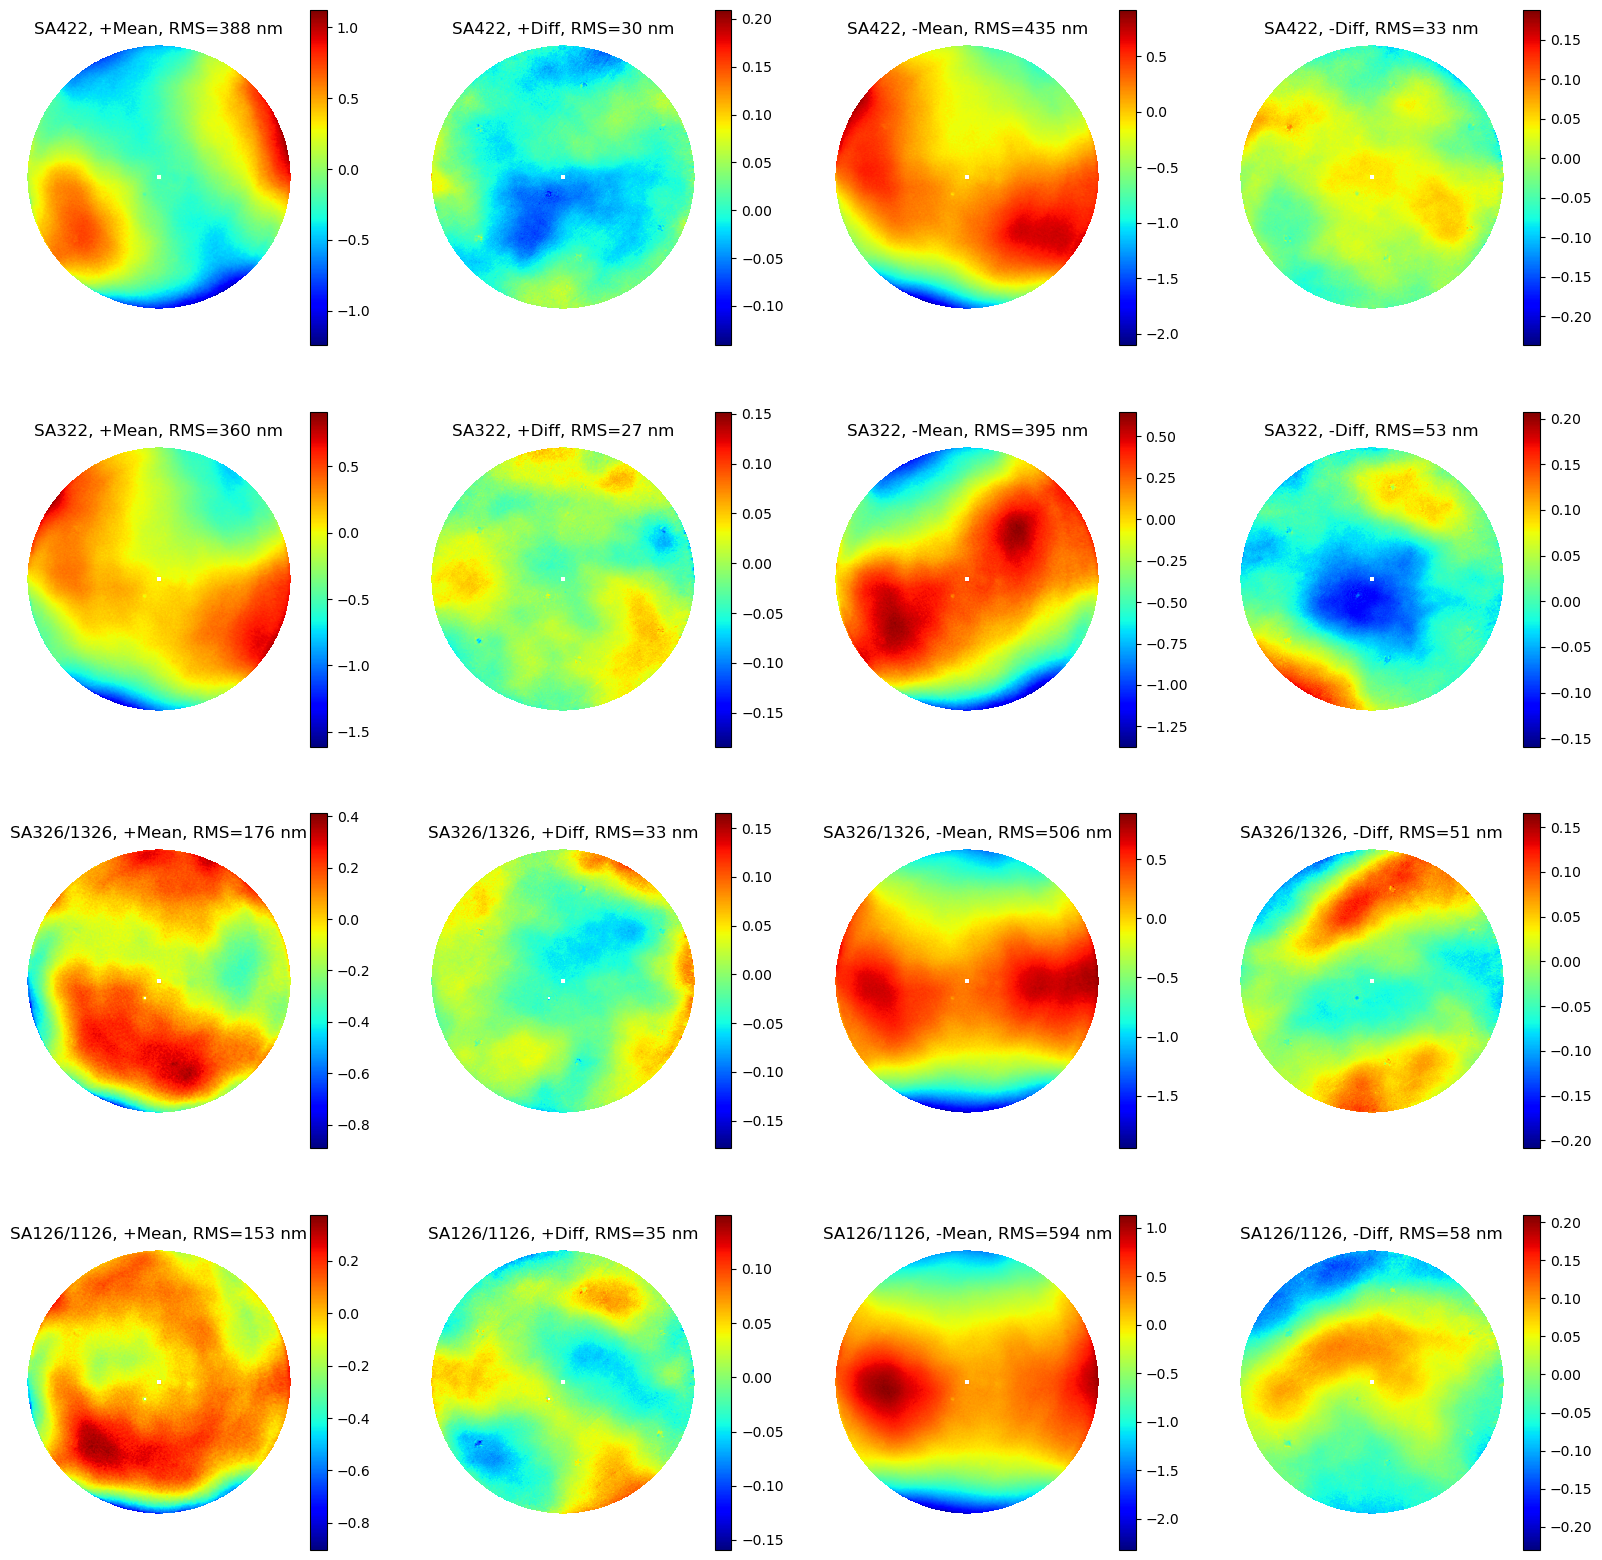

In [4]:
#look at average and diff of each ++ pair and each -- pair
stats = np.zeros((4, nSA))
fig, ax = plt.subplots(nSA,4,figsize=(20,5*nSA))
i = 0
for mysaID in repeat_IDs:

    aveplus = np.zeros_like(m1s)
    aveminus = np.zeros_like(m1s)
    diffplus = np.zeros_like(m1s)
    diffminus = np.zeros_like(m1s)
    signedBend = ['set1*act%d +'%mysaID, 'set1*act%d -'%mysaID,'set2*act%d -'%mysaID, 'set2*act%d +'%mysaID ]
    signshort = '+--+'
    for bend in signedBend:

        globstring = '%s/Sec 9/*%s*-.h5'%(ml_data_dir, bend)
        if (mysaID in BX_IDs and mysaID in repeat_IDs):
            globstring = globstring.replace('Sec 9', 'Sec 9 Take 2')
            globstring = globstring.replace('act%d '%mysaID, 'sa%d'%mysaID)
        #print(globstring)
        fileset = sorted(glob.glob(globstring))
        #print(fileset)
        m1s,centerRow1,centerCol1,pixelSize1, ts = readH5Map(fileset, verbose=False)
        if '+' in bend:
            aveplus += m1s
            if 'set1' in bend:
                diffplus -= m1s
            else:
                diffplus += m1s #set2 - set1
                aveplus /= 2
        else:
            aveminus += m1s
            if 'set1' in bend:
                diffminus -= m1s
            else:
                diffminus += m1s
                aveminus /= 2
    for j in range(4):
        irow = np.int8(i/4)
        icol = np.mod(i,4)
        i += 1
        if j==0:
            m1s = aveplus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'SA%d, +Mean, RMS=%.0f nm'%(mysaID, m1rms)
        elif j==1:
            m1s = diffplus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'SA%d, +Diff, RMS=%.0f nm'%(mysaID, m1rms)           
        elif j==2:
            m1s = aveminus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'SA%d, -Mean, RMS=%.0f nm'%(mysaID, m1rms)
        elif j==3:
            m1s = diffminus
            img = ax[irow][icol].imshow(m1s, origin='lower')
            fig.colorbar(img, ax=ax[irow][icol])
            m1rms = np.std(m1s[~np.isnan(m1s)])*1000 #convert into nm
            mytitle = 'SA%d, -Diff, RMS=%.0f nm'%(mysaID, m1rms)  
        if mysaID+1000 in TR_IDs:
            mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
        ax[irow][icol].set_title(mytitle)
        ax[irow][icol].axis('off')
        stats[j, np.argmax(repeat_IDs==mysaID)] = m1rms

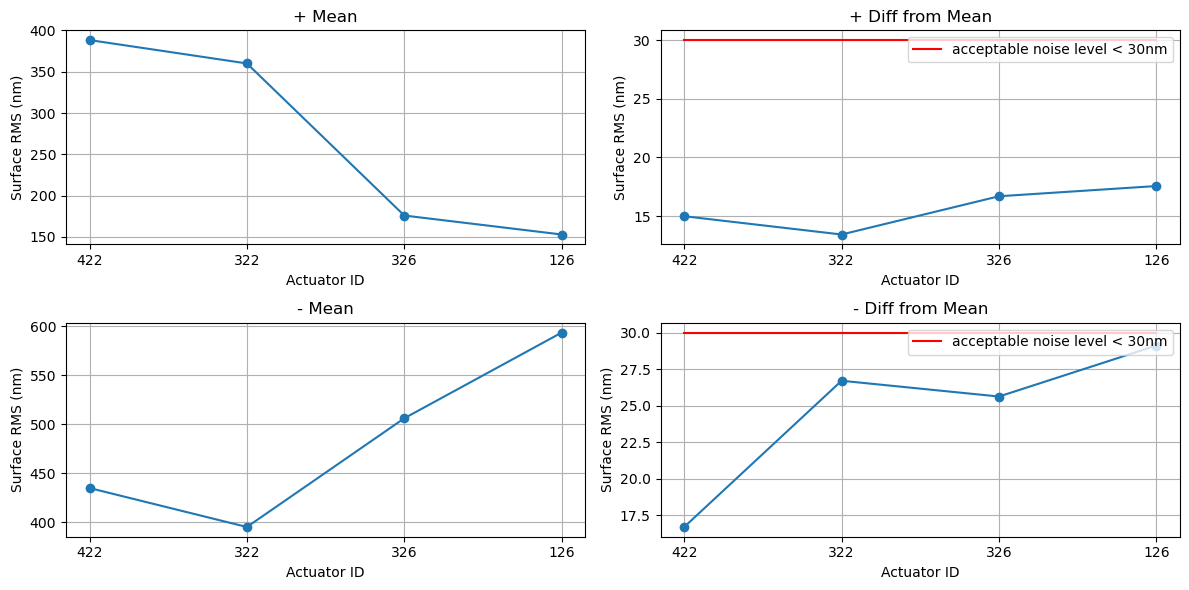

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12, 6))
i = 0
j = 0
ax[i][j].plot(stats[0,:],'-o')
ax[i][j].set_xticks(ticks=np.arange(nSA), labels=['%d'%i for i in repeat_IDs])
ax[i][j].grid()
ax[i][j].set_xlabel('Actuator ID')
ax[i][j].set_title('+ Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 0
j = 1
ax[i][j].plot(stats[j,:]/2,'-o')
ax[i][j].plot([0, nSA-1],[30,30],'-r', label='acceptable noise level < 30nm')
ax[i][j].set_xticks(ticks=np.arange(nSA), labels=['%d'%i for i in repeat_IDs])
ax[i][j].grid()
ax[i][j].legend(loc='upper right')
ax[i][j].set_xlabel('Actuator ID')
ax[i][j].set_title('+ Diff from Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 1
j = 0
ax[i][j].plot(stats[2,:],'-o')
ax[i][j].set_xticks(ticks=np.arange(nSA), labels=['%d'%i for i in repeat_IDs])
ax[i][j].grid()
ax[i][j].set_xlabel('Actuator ID')
ax[i][j].set_title('- Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')
i = 1
j = 1
ax[i][j].plot(stats[3,:]/2,'-o')
ax[i][j].plot([0, nSA-1],[30,30],'-r', label='acceptable noise level < 30nm')
ax[i][j].set_xticks(ticks=np.arange(nSA), labels=['%d'%i for i in repeat_IDs])
ax[i][j].grid()
ax[i][j].legend(loc='upper right')
ax[i][j].set_xlabel('Actuator ID')
ax[i][j].set_title('- Diff from Mean')
ax[i][j].set_ylabel('Surface RMS (nm)')

plt.tight_layout()


#### Now calculate the single SA influence fuctions

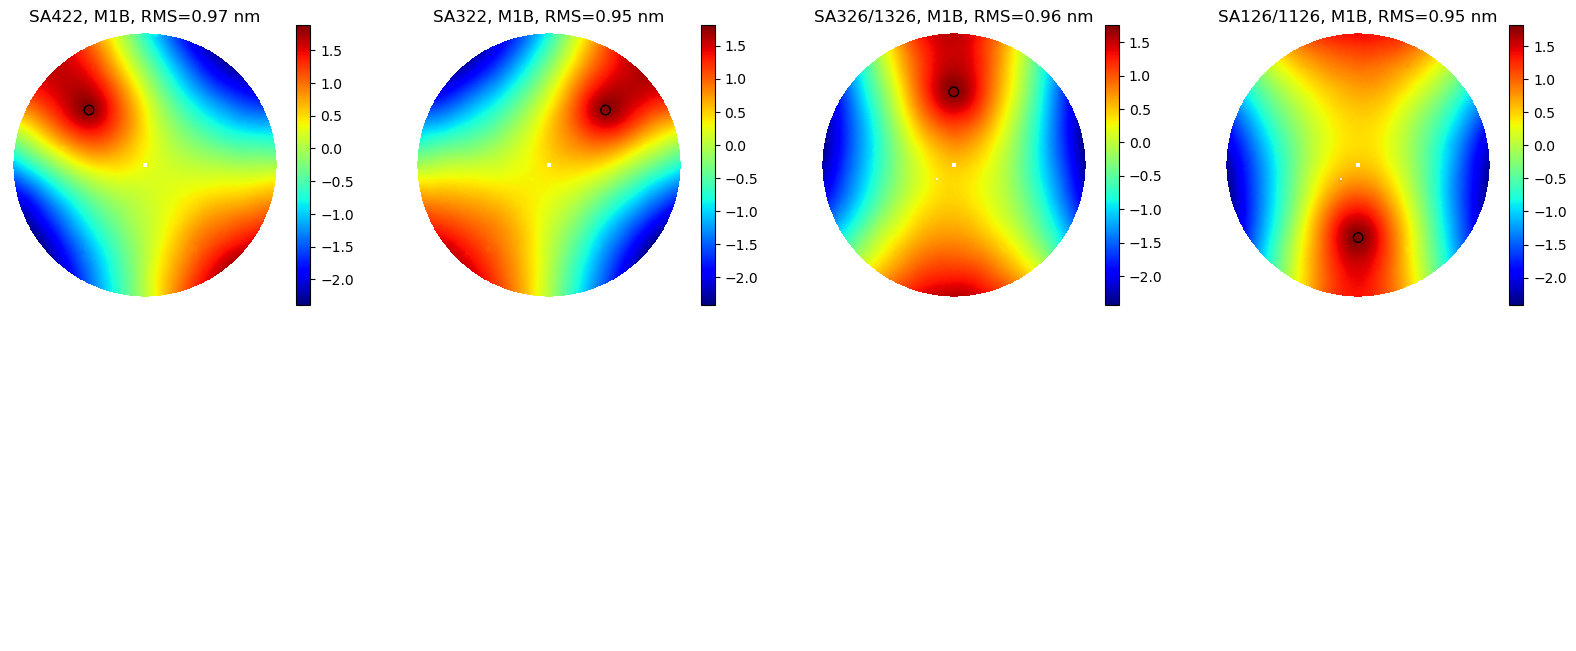

In [6]:
myIF = np.zeros((Sxn, Syn, nSA))
nrow = np.max((int(np.ceil(nSA/4.)),2))
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for mysaID in repeat_IDs:
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1

    signedBend = ['set1*act%d +'%mysaID, 'set1*act%d -'%mysaID,'set2*act%d -'%mysaID, 'set2*act%d +'%mysaID ]
    signshort = '+--+'    
    for bend in signedBend:
        globstring = '%s/Sec 9/*%s*-.h5'%(ml_data_dir, bend)
        if (mysaID in BX_IDs and mysaID in repeat_IDs):
            globstring = globstring.replace('Sec 9', 'Sec 9 Take 2')
            globstring = globstring.replace('act%d '%mysaID, 'sa%d'%mysaID)
        #print(globstring)
        fileset = sorted(glob.glob(globstring))
        #print(fileset)
        m1s,centerRow,centerCol,pixelSize, ts = readH5Map(fileset, verbose=False)
        if '+' in bend:
            myIF[:,:,i-1] += m1s
        else:
            myIF[:,:,i-1] -= m1s
    myIF[:,:,i-1] /= (4*300) #300N, normalize to 1N
    myIF[:,:,i-1] = -myIF[:,:,i-1].T *1000 #convert into nm
    m1s = myIF[:,:,i-1]
    m1rms = np.std(m1s[~np.isnan(m1s)])

    img = ax[irow][icol].imshow(m1s, origin='lower')
    fig.colorbar(img, ax=ax[irow][icol])
    mytitle = 'SA%d, M1B, RMS=%.2f nm'%(mysaID, m1rms)
    if mysaID+1000 in TR_IDs:
        mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
    ax[irow][icol].set_title(mytitle)
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[irow][icol].add_artist(circle)
    ax[irow][icol].axis('off')
for i in range(nSA, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')

## GMT single SA IF (influenceMat * [0 0 1 0 0 ... 0])

In [7]:
#differentiating singles from triples
idx = np.zeros(nact)
for ii in range(nact):
    if saID[ii] in repeat_IDs:
        if saz[ii]>0.04:
            idx[ii] = 1
        else:
            idx[ii] = 3

Text(0.5, 1.0, 'Actuator IDs and locations in M1-B Coordinate System')

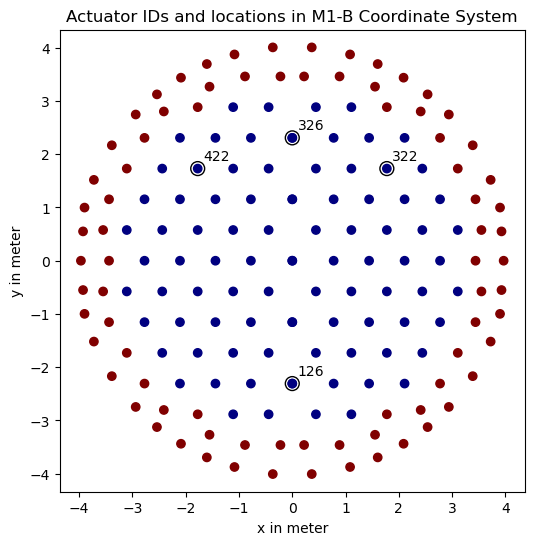

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(sax, say, c=saz)
plt.scatter(sax[idx!=0], say[idx!=0], s=100, facecolors='none', edgecolors='k')
for i in range(len(sax)):
    if idx[i] != 0:
        if (np.any(abs(sax[i]+say[i]-sax[:i]-say[:i])<1e-4)):
            plt.text(sax[i]+.1, say[i]-0.25, str(saID[i]))
        else:
            plt.text(sax[i]+.1, say[i]+0.15, str(saID[i]))
plt.axis('equal')
plt.xlabel('x in meter')
plt.ylabel('y in meter')
plt.title('Actuator IDs and locations in M1-B Coordinate System')

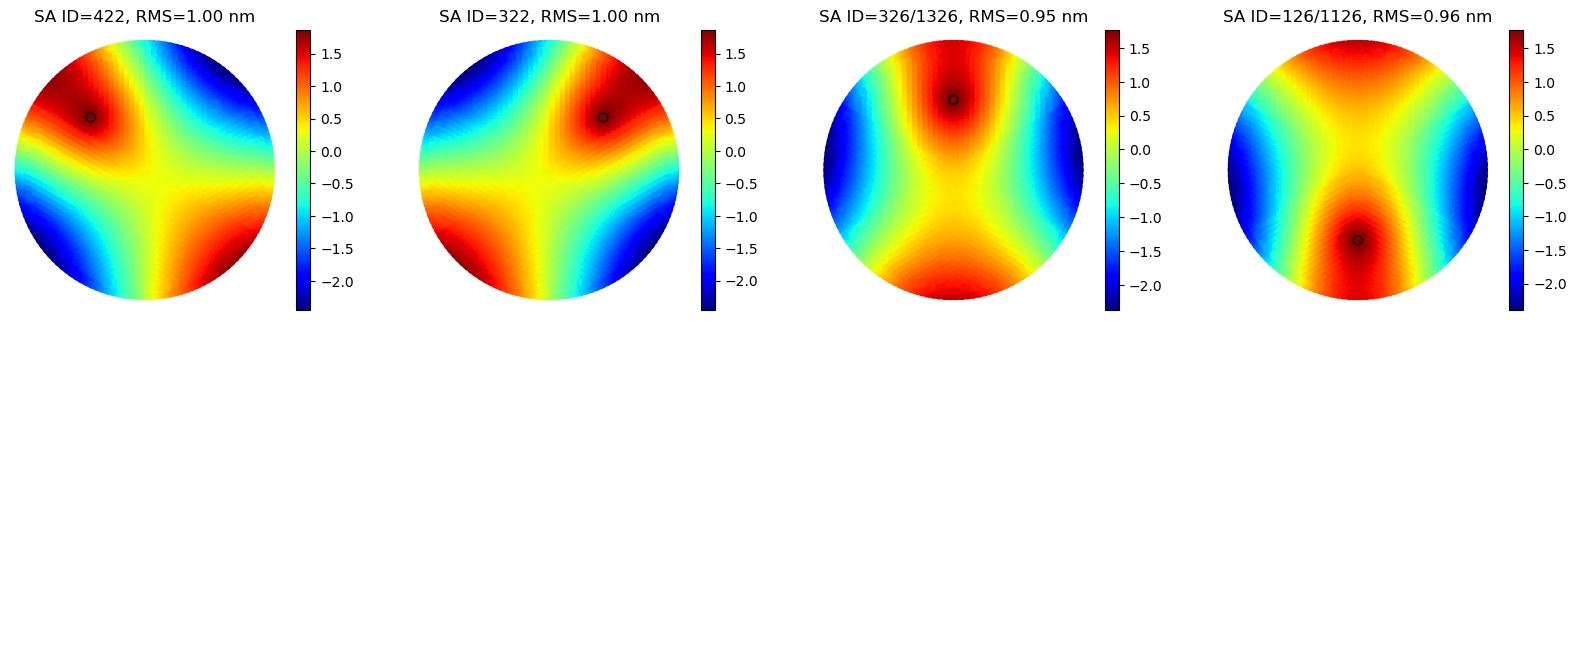

In [9]:
nrow = np.max((int(np.ceil(nSA/4.)),2))
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for mysaID in repeat_IDs:

    modeID = np.argmax(saID==mysaID)+1
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1

    img = ax[irow][icol].scatter(nodex, nodey,10, Afz[:,modeID-1]*1e9) #unit to nm
    m1rms = np.std(Afz[:,modeID-1]*1e9)
    if mysaID in TR_IDs[:10]:
        ax[irow][icol].set_title('SA ID=%d/%d, RMS=%.2f nm'%(saID[modeID-1], saID[modeID-1]+1000, m1rms))
    else:
        ax[irow][icol].set_title('SA ID=%d, RMS=%.2f nm'%(saID[modeID-1],m1rms))
    circle = plt.Circle((sax[modeID-1], say[modeID-1]),0.15, fill=False)
    ax[irow][icol].add_artist(circle)
    ax[irow][icol].axis('equal')
    ax[irow][icol].axis('off')
    fig.colorbar(img, ax=ax[irow][icol])
endMode = i
for i in range(endMode, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')

#### Perform a least-square fit for each influence function using the FEM-determined influence function. Check the scaling factor and residual from fit. Normalize the residual to 1 N force on the actuator being tested.

SA422, Scaling factor =0.968, Residual RMS = 0.063 nm (per N force)
SA322, Scaling factor =0.951, Residual RMS = 0.043 nm (per N force)
SA326/1326, Scaling factor =1.016, Residual RMS = 0.049 nm (per N force)
SA126/1126, Scaling factor =0.995, Residual RMS = 0.039 nm (per N force)
scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.


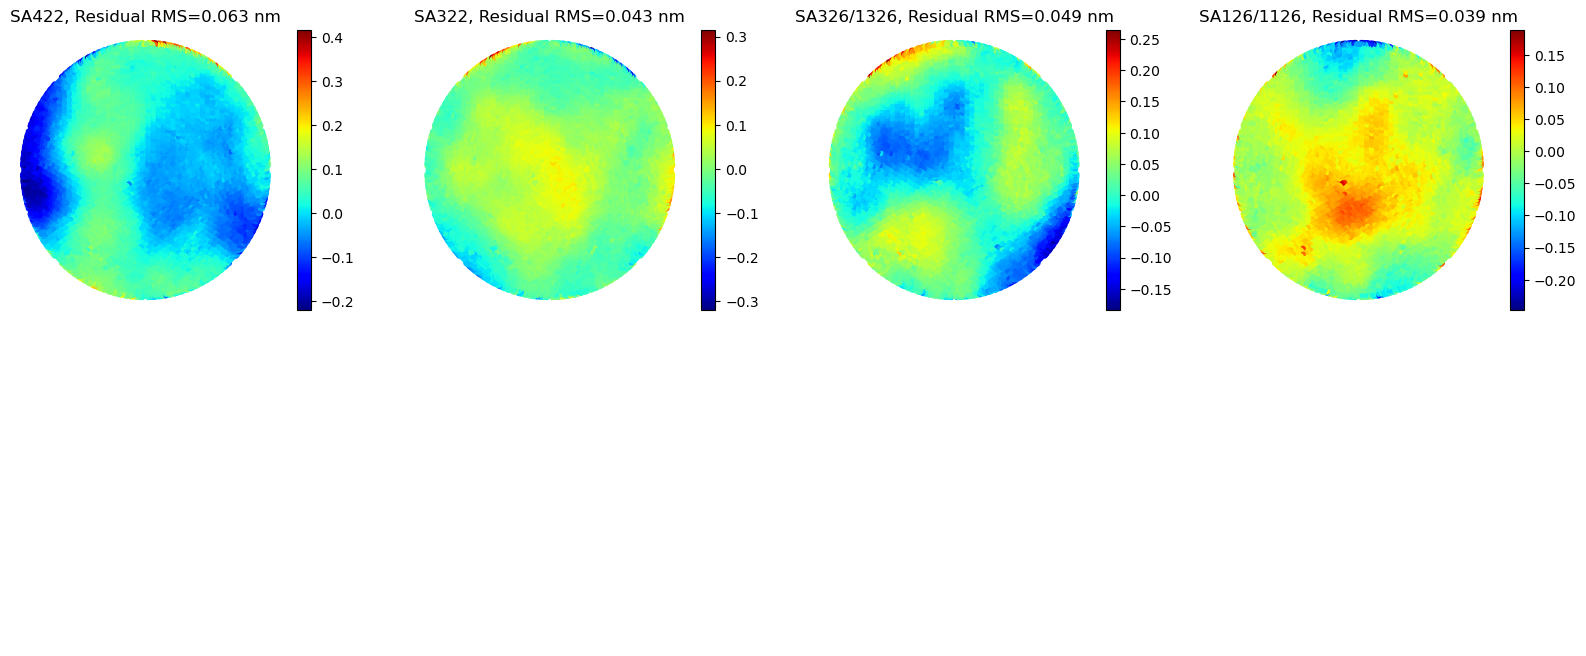

In [20]:
#These 2D interpolations between large grids take a few minutes to run

from scipy.interpolate import LinearNDInterpolator 

scaleF = np.zeros((nSA, 1))
#[x1, y1] are the x and y grid in M1B. 
#CenterCol and centerRow are swapped, because they were meant for h5 CS
#Lines below, we will transpose the h5 map to match this.
#.  we will also reverse the sign of h5 maps to be in M1B.
[x1, y1] = mkXYGrid(m1s, centerCol, centerRow, pixelSize)

nrow = np.max((int(np.ceil(nSA/4.)),2))
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for mysaID in repeat_IDs:
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1

    if2d = np.squeeze(myIF[:,:,i-1]) #myIF is already in M1B, in nm
    mask = ~np.isnan(if2d)

    interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), if2d[mask], fill_value=0)
    mapOntoGMTFEgrid = interp(nodex, nodey).ravel()
    validIdx = mapOntoGMTFEgrid!=0
    scaleF[i-1] = np.linalg.pinv(Afz170[validIdx,saID==mysaID].reshape((-1,1))*1e9)  @ mapOntoGMTFEgrid[validIdx] #all in nm
    residual = mapOntoGMTFEgrid[validIdx] - scaleF[i-1]* np.squeeze(Afz170[validIdx,saID==mysaID])*1e9 #this is residual
    
    m1rms = np.std(residual[~np.isnan(residual)]) #already in nm
    mytitle = 'SA%d, Scaling factor =%.3f, Residual RMS = %.3f nm (per N force)'%(mysaID, scaleF[i-1], m1rms)
    if mysaID+1000 in TR_IDs[:10]:
        mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
    print(mytitle)
    
    img = ax[irow][icol].scatter(nodex[validIdx], nodey[validIdx], 10, residual)#, vmin=-0.2, vmax=0.2)
    fig.colorbar(img, ax=ax[irow][icol])
    mytitle = 'SA%d, Residual RMS=%.3f nm'%(mysaID, m1rms)
    if mysaID+1000 in TR_IDs:
        mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
    ax[irow][icol].set_title(mytitle)
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[irow][icol].add_artist(circle)
    ax[irow][icol].axis('off')
for i in range(nSA, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')
print('scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.')

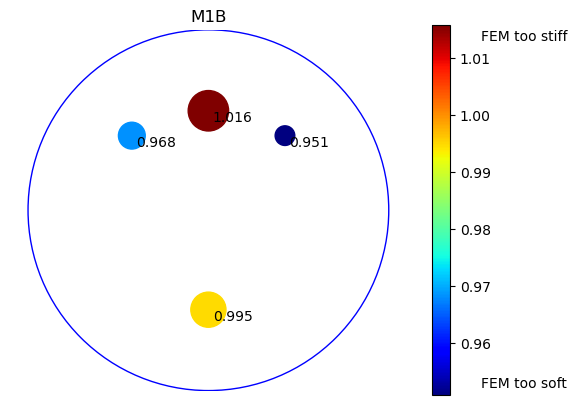

In [30]:
idx = [np.argmax(saID==i) for i in repeat_IDs]

fig, ax = plt.subplots()
plt.scatter(sax[idx], say[idx], (scaleF-(np.min(scaleF-0.02)))*1e4, c=scaleF)
circle = plt.Circle((0., 0.), radius_of_CA, color='blue', fill=False)
ax.add_artist(circle)
ax.axis('square')
ax.set_xlim(-radius_of_CA*1.1, radius_of_CA*1.1)
ax.set_ylim(-radius_of_CA, radius_of_CA)

cbar = plt.colorbar()
cbar.ax.text(5, 0.95, 'FEM too stiff', ha='center', va='bottom', transform=cbar.ax.transAxes)
cbar.ax.text(5, 0.05, 'FEM too soft', ha='center', va='top', transform=cbar.ax.transAxes)
plt.title('M1B')
plt.axis('off')
j=0
for i in idx:
    plt.text(sax[i]+.1, say[i]-0.25, '%.3f'%scaleF[j])
    j+=1

In [31]:
np.savetxt('../model_data/GMT_SA_IF_repeats.txt', np.column_stack((repeat_IDs, scaleF)))

### We use this SA to look into what happened.

In [32]:
mysaID = int(422)

In [34]:
#redo this just to get the timestamps for the +--+ measurements
ts_array = []
signedBend = ['set1*act%d +'%mysaID, 'set1*act%d -'%mysaID,'set2*act%d -'%mysaID, 'set2*act%d +'%mysaID ]
signshort = '+--+'
for bend in signedBend:

    globstring = '%s/Sec 9/*%s*-.h5'%(ml_data_dir, bend)
    if (mysaID in BX_IDs and mysaID in repeat_IDs):
        globstring = globstring.replace('Sec 9', 'Sec 9 Take 2')
        globstring = globstring.replace('act%d '%mysaID, 'sa%d'%mysaID)
    #print(globstring)
    fileset = sorted(glob.glob(globstring))
    #print(fileset)
    assert len(fileset)==1
    m1s,centerRow1,centerCol1,pixelSize1, ts = readH5Map(fileset)
    ts_array.append(ts)

/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa422+ gmtMorph170614 -.h5: Wed Jan 29 15:52:44 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set1 9.2 5-7 GMTO sa422- gmtMorph170614 -.h5: Wed Jan 29 15:56:39 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set2 9.2 5-7 GMTO sa422- gmtMorph170614 -.h5: Wed Jan 29 16:00:02 2025 
/Users/bxin/GMT_docs/1_M1/Analysis/ml_data/data/Optical Data//Sec 9 Take 2/250129 GMT3 set2 9.2 5-7 GMTO sa422+ gmtMorph170614 -.h5: Wed Jan 29 16:04:11 2025 


In [35]:
#these can indices for ts_array, just so that we can reuse some code for BM investigations
t1=0
t2=1
t3=2
t4=3

In [37]:
def showTMaps(tss):
    #timestamps (tss) example: 
    #["Fri Jan 10 14:04:57 2025", "Fri Jan 10 14:14:57 2025", "Fri Jan 10 15:20:57 2025", "Fri Jan 10 15:30:57 2025"]

    # Define the grid for interpolation
    grid_size = 500  # Resolution of the grid
    xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
    yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
    xi, yi = np.meshgrid(xi, yi)

    # Create a circular mask for the given radius
    mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

    # Plot the result
    fig, ax = plt.subplots(len(tss),3,figsize=(18,4*len(tss)))
    for i,ts in enumerate(tss):
        print('----------------  ', ts)#, unix_ts(ts))
        tc, tt = getDBData(unix_ts(ts),'m1_s1_thermal_ctrl/i/tc_temperature/value', duration_in_s=100, samples=1)
        #back plate
        x = tc_locs[idx_mirror_b][:,0] 
        y = tc_locs[idx_mirror_b][:,1]
        z = tc[0,idx_mirror_b]
        # Interpolate z-values to the grid
        zi = griddata((x, y), z, (xi, yi), method='linear')
        zi[~mask] = np.nan  # Set values outside the circle to NaN
        
        contour = ax[i][0].contourf(xi, yi, zi, levels=100, cmap='jet')
        fig.colorbar(contour, ax=ax[i][0])#, label='')
        ax[i][0].scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
        ax[i][0].set_aspect('equal', adjustable='box')
        ax[i][0].set_title('Back, PV = %.2f K, %s'%(np.max(z)-np.min(z), ts))
        #ax[i][0].set_xlabel('X (m)')
        ax[i][0].set_ylabel('Y (m)')
        ax[i][0].legend()
        
        #levels = np.linspace(np.min(z), np.max(z), 100)
        #front plate
        x = tc_locs[idx_mirror_f][:,0] 
        y = tc_locs[idx_mirror_f][:,1]
        z = tc[0,idx_mirror_f]
        zi = griddata((x, y), z, (xi, yi), method='linear')
        zi[~mask] = np.nan  # Set values outside the circle to NaN
        
        contour = ax[i][1].contourf(xi, yi, zi, levels=100, cmap='jet')
        fig.colorbar(contour, ax=ax[i][1])#, label='Z values')
        ax[i][1].scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
        ax[i][1].set_aspect('equal', adjustable='box')
        ax[i][1].set_title('Front, PV = %.2f K, %s'%(np.max(z)-np.min(z), ts))
        #ax[i][0].set_xlabel('X (m)')
        ax[i][1].set_ylabel('Y (m)')
        ax[i][1].legend()
        
        #back-front
        z = tc[0,idx_mirror_b] - tc[0,idx_mirror_f]
        zi = griddata((x, y), z, (xi, yi), method='linear')
        zi[~mask] = np.nan  # Set values outside the circle to NaN
        
        contour = ax[i][2].contourf(xi, yi, zi, levels=100, cmap='jet')
        fig.colorbar(contour, ax=ax[i][2])#, label='Z values')
        ax[i][2].scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
        ax[i][2].set_aspect('equal', adjustable='box')
        ax[i][2].set_title('Back-Front, PV = %.2f K, %s'%(np.max(z)-np.min(z), ts))
        #ax[i][0].set_xlabel('X (m)')
        ax[i][2].set_ylabel('Y (m)')
        ax[i][2].legend()
    plt.show()

----------------   Wed Jan 29 15:52:44 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-29 15:52:44  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Wed Jan 29 15:56:39 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-29 15:56:39  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Wed Jan 29 16:00:02 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-29 16:00:02  duration =  100  s
(1, 6, 32)
(1, 192)
----------------   Wed Jan 29 16:04:11 2025
m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-29 16:04:11  duration =  100  s
(1, 6, 32)
(1, 192)


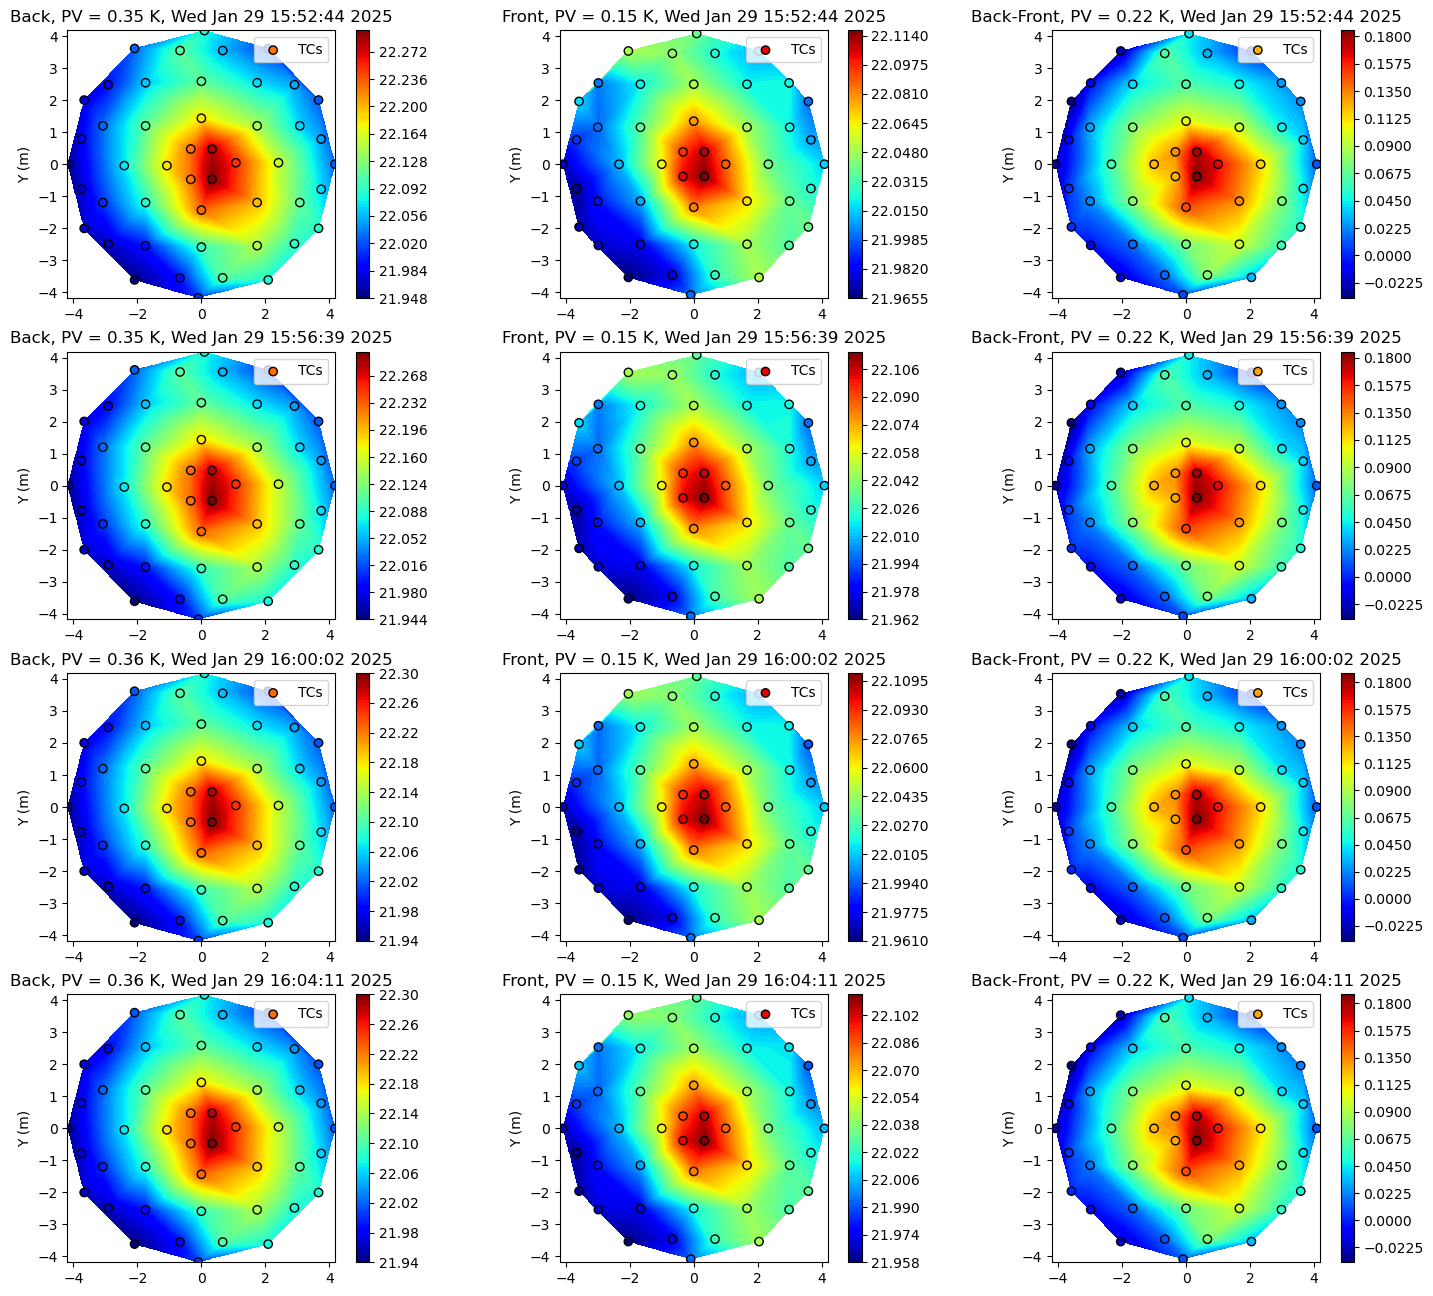

In [38]:
showTMaps([ts_array[t1], ts_array[t2], ts_array[t3], ts_array[t4]])

### Check force telemetry: force differential

In [39]:
print(t1, t2)
sa_force1, tt = getDBData(unix_ts(ts_array[t1])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force1_ave = np.mean(sa_force1,axis=0)
print(sa_force1.shape)
sa_force2, tt = getDBData(unix_ts(ts_array[t2])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force2_ave = np.mean(sa_force2,axis=0)
print(sa_force2.shape)
sa_force3, tt = getDBData(unix_ts(ts_array[t3])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force3_ave = np.mean(sa_force3,axis=0)
print(sa_force3.shape)
sa_force4, tt = getDBData(unix_ts(ts_array[t4])-120,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=120, samples=120)
sa_force4_ave = np.mean(sa_force4,axis=0)
print(sa_force4.shape)

0 1
m1_s1_support_ctrl/s/sa_force/value
2025-01-29 15:50:44  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-29 15:54:39  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-29 15:58:02  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/s/sa_force/value
2025-01-29 16:02:11  duration =  120  s
(120, 170, 3)
(120, 170, 3)
(120, 170, 3)


input forces and output figure both in M1B


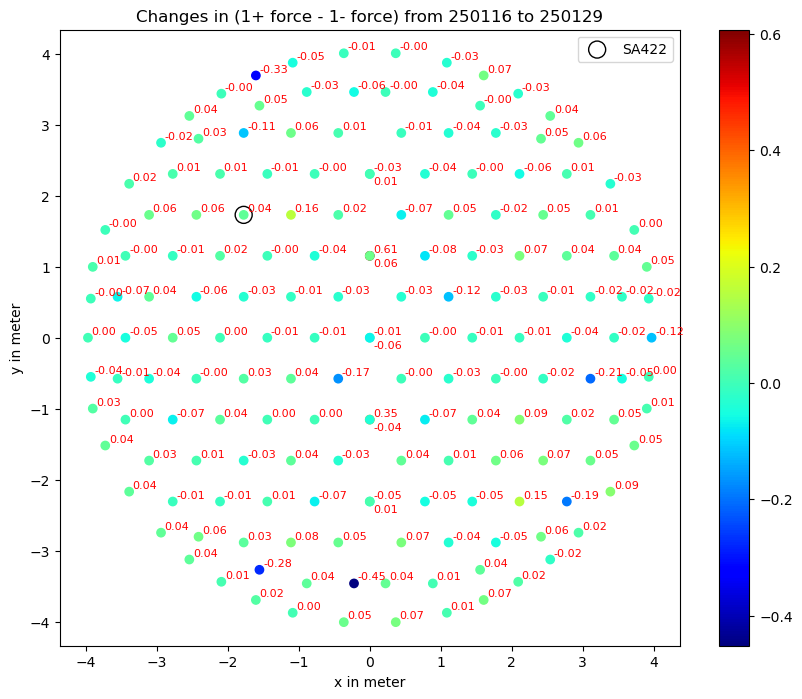

In [46]:
fdiff1 = (sa_force1_ave[:,2]-sa_force2_ave[:,2]) #- expectedF*bmMags[modeID-1]
fdiff1_prev = np.loadtxt('../temp_data/fdiff1_SA422_250116.txt')
showForceMap_M1B(fdiff1-fdiff1_prev, 'Changes in (1+ force - 1- force) from 250116 to 250129', precision=2)
plt.scatter(sax[saID==mysaID], say[saID==mysaID], s=150, facecolors='none', edgecolors='k', label='SA%d'%mysaID)
plt.legend();

In [47]:
##find the force command from DB
fcmd1, tt = getDBData(unix_ts(ts_array[t1])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd2, tt = getDBData(unix_ts(ts_array[t2])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd3, tt = getDBData(unix_ts(ts_array[t3])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)
fcmd4, tt = getDBData(unix_ts(ts_array[t4])-120,'m1_s1_support_ctrl/i/sa_force_commanded/value', duration_in_s=120, samples=120)

m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-29 15:50:44  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-29 15:54:39  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-29 15:58:02  duration =  120  s
(120, 170, 3)
(120, 170, 3)
m1_s1_support_ctrl/i/sa_force_commanded/value
2025-01-29 16:02:11  duration =  120  s
(120, 170, 3)
(120, 170, 3)


In [48]:
fdiff_inst_1 = sa_force1[:,:,2] - fcmd1[:,:,2]
fdiff_inst_2 = sa_force2[:,:,2] - fcmd2[:,:,2]
fdiff_inst_3 = sa_force3[:,:,2] - fcmd3[:,:,2]
fdiff_inst_4 = sa_force4[:,:,2] - fcmd4[:,:,2]

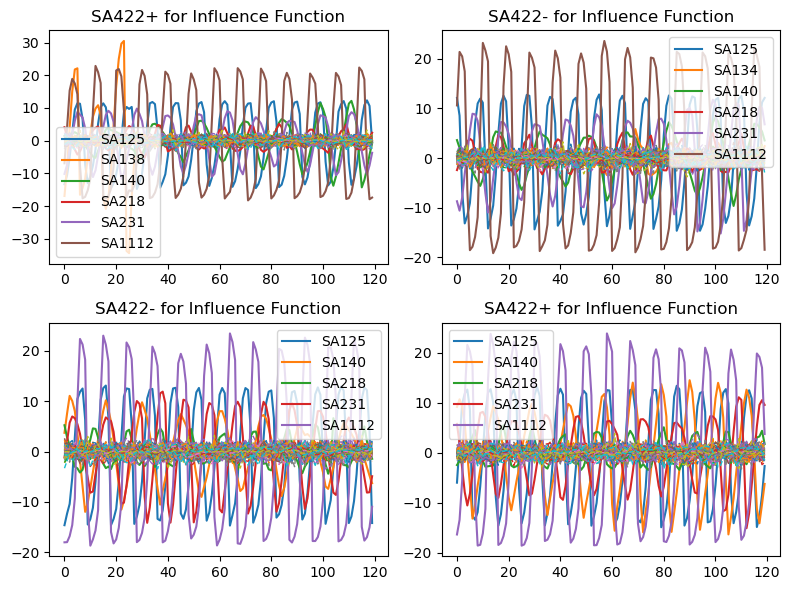

In [49]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

for k in range(4):
    irow = np.int8(k//2)
    icol = np.mod(k,2)
    if k==0:
        fol_err = fdiff_inst_1 
    elif k==1:
        fol_err = fdiff_inst_2
    elif k==2:
        fol_err = fdiff_inst_3
    elif k==3:
        fol_err = fdiff_inst_4

    thres = 5
    for i in range(nact):
        if np.max(np.abs(fol_err[:,i]))>thres:
            ax[irow][icol].plot(fol_err[:,i], label='SA%s'%(saID[i+1]))
    ax[irow][icol].legend()
    ax[irow][icol].set_title('SA%d%s for Influence Function'%(mysaID, signshort[k]))
    for i in range(nact):
        if np.max(np.abs(fol_err[:,i]))<=thres:
            ax[irow][icol].plot(fol_err[:,i], '--', linewidth=1)
plt.tight_layout()

### What if we fit these to the ML influence functions? The force distributions slightly differ....

In [12]:
IF_ml = Afn_ml @ fv_ml

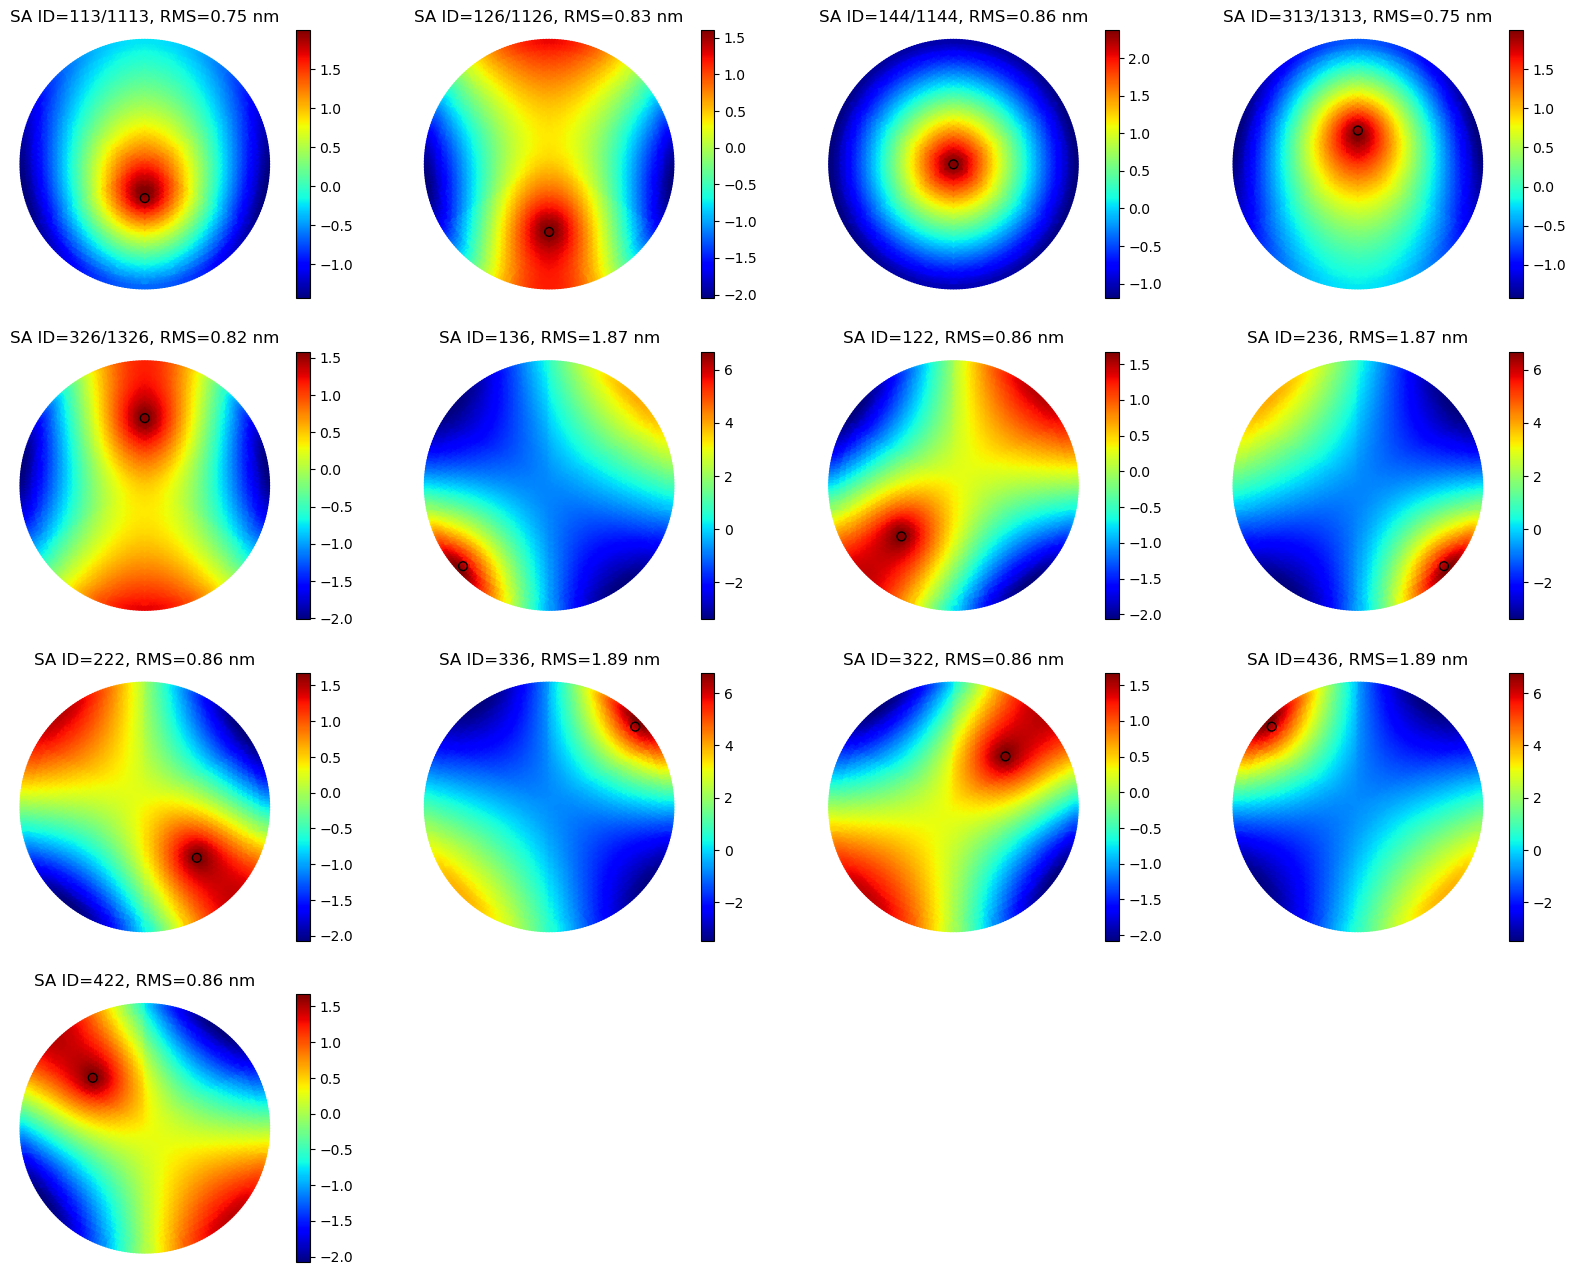

In [13]:
nrow = 4
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for mysaID in TR_IDs:

    if mysaID < 1000:
        modeID_ml = saID2mlModeID(mysaID) #modeID_ml is in the range [1, 165]
        irow = np.int8(i/4)
        icol = np.mod(i,4)
        i += 1

        img = ax[irow][icol].scatter(nodex_ml, nodey_ml,10, IF_ml[:,modeID_ml-1]) #unit is nm
        m1rms = np.std(IF_ml[:,modeID_ml-1])
        if mysaID in TR_IDs[:10]:
            ax[irow][icol].set_title('SA ID=%d/%d, RMS=%.2f nm'%(mysaID, mysaID+1000, m1rms))
        else:
            ax[irow][icol].set_title('SA ID=%d, RMS=%.2f nm'%(mysaID,m1rms))
        circle = plt.Circle((sax_ml[modeID_ml-1], say_ml[modeID_ml-1]),0.15, fill=False)
        ax[irow][icol].add_artist(circle)
        ax[irow][icol].axis('equal')
        ax[irow][icol].axis('off')
        fig.colorbar(img, ax=ax[irow][icol])
endMode = i
for i in range(endMode, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')

SA113/1113, Scaling factor =1.096, Residual RMS = 0.084 nm (per N force)
SA126/1126, Scaling factor =1.154, Residual RMS = 0.051 nm (per N force)
SA144/1144, Scaling factor =1.070, Residual RMS = 0.079 nm (per N force)
SA313/1313, Scaling factor =1.074, Residual RMS = 0.079 nm (per N force)
SA326/1326, Scaling factor =1.121, Residual RMS = 0.054 nm (per N force)
SA136, Scaling factor =1.154, Residual RMS = 0.089 nm (per N force)
SA122, Scaling factor =1.124, Residual RMS = 0.040 nm (per N force)
SA236, Scaling factor =1.165, Residual RMS = 0.082 nm (per N force)
SA222, Scaling factor =1.123, Residual RMS = 0.046 nm (per N force)
SA336, Scaling factor =1.154, Residual RMS = 0.122 nm (per N force)
SA322, Scaling factor =1.109, Residual RMS = 0.046 nm (per N force)
SA436, Scaling factor =1.153, Residual RMS = 0.141 nm (per N force)
SA422, Scaling factor =1.090, Residual RMS = 0.053 nm (per N force)
scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.


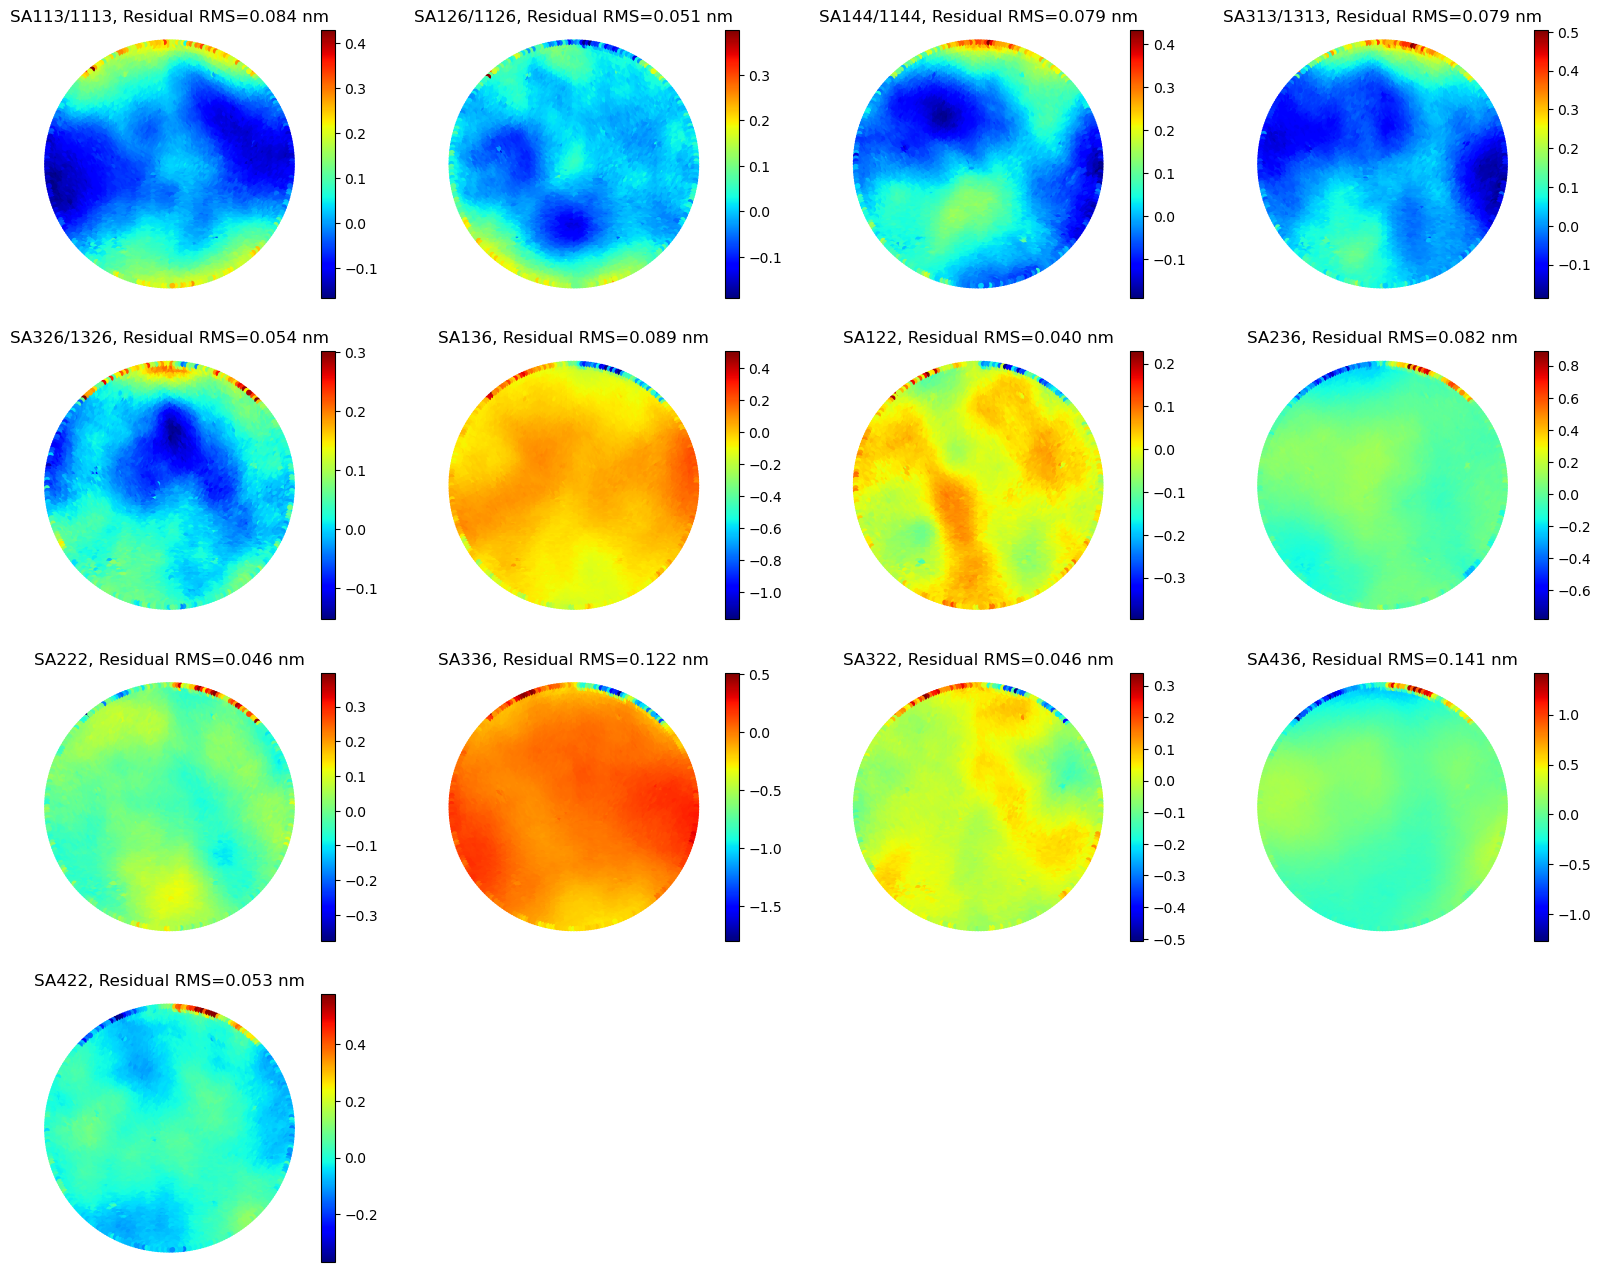

In [14]:
#These 2D interpolations between large grids take a few minutes to run

scaleF_ml = np.zeros((nSA, 1))
[x1, y1] = mkXYGrid(m1s, centerRow, centerCol, pixelSize)

nrow = int(np.ceil(nSA/4.))
fig, ax = plt.subplots(nrow,4,figsize=(20,4*nrow))
i = 0
for mysaID in TR_IDs_unique:
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    i += 1

    if2d = np.squeeze(myIF[:,:,i-1]) #myIF is already in M1B, in nm
    mask = ~np.isnan(if2d)

    modeID_ml = saID2mlModeID(mysaID) #modeID_ml is in the range [1, 165]
    interp = LinearNDInterpolator(list(zip(x1[mask], y1[mask])), if2d[mask], fill_value=0)
    mapOntoMLFEgrid = interp(nodex_ml, nodey_ml).ravel()
    scaleF_ml[i-1] = np.linalg.pinv(IF_ml[:,modeID_ml-1].reshape(-1,1))  @ mapOntoMLFEgrid #all in nm
    residual = mapOntoMLFEgrid - scaleF_ml[i-1]* np.squeeze(IF_ml[:,modeID_ml-1]) #this is residual
    
    m1rms = np.std(residual[~np.isnan(residual)]) #already in nm
    mytitle = 'SA%d, Scaling factor =%.3f, Residual RMS = %.3f nm (per N force)'%(mysaID, scaleF_ml[i-1], m1rms)
    if mysaID+1000 in TR_IDs:
        mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
    print(mytitle)
    
    img = ax[irow][icol].scatter(nodex_ml, nodey_ml, 10, residual)
    fig.colorbar(img, ax=ax[irow][icol])
    mytitle = 'SA%d, Residual RMS=%.3f nm'%(mysaID, m1rms)
    if mysaID+1000 in TR_IDs:
        mytitle = mytitle.replace('%d'%mysaID, '%d/%d'%(mysaID, mysaID+1000))
    ax[irow][icol].set_title(mytitle)
    circle = plt.Circle((saID2pixx(mysaID, centerRow, centerCol, pixelSize), 
                         saID2pixy(mysaID, centerRow, centerCol, pixelSize)),15, fill=False)
    ax[irow][icol].add_artist(circle)
    ax[irow][icol].axis('off')
for i in range(nSA, nrow*4):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    ax[irow][icol].axis('off')
print('scaling factor <1 means mirror stiffer than FEM, i.e., model too soft.')

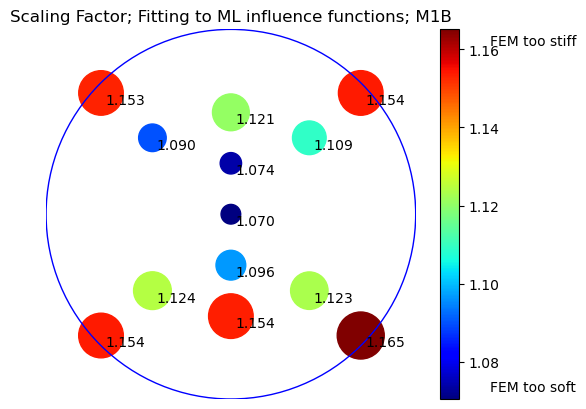

In [17]:
idx = [np.argmax(saID==i) for i in TR_IDs_unique]

fig, ax = plt.subplots()
plt.scatter(sax[idx], say[idx], (scaleF_ml-(np.min(scaleF_ml)-0.02))*1e4, c=scaleF_ml)
circle = plt.Circle((0., 0.), radius_of_CA, color='blue', fill=False)
ax.add_artist(circle)
ax.axis('square')
ax.set_xlim(-radius_of_CA, radius_of_CA)
ax.set_ylim(-radius_of_CA, radius_of_CA)

cbar = plt.colorbar()
cbar.ax.text(5, 0.95, 'FEM too stiff', ha='center', va='bottom', transform=cbar.ax.transAxes)
cbar.ax.text(5, 0.05, 'FEM too soft', ha='center', va='top', transform=cbar.ax.transAxes)
plt.title('Scaling Factor; Fitting to ML influence functions; M1B')
plt.axis('off')
j=0
for i in idx:
    plt.text(sax[i]+.1, say[i]-0.25, '%.3f'%scaleF_ml[j])
    j+=1